In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import glob
import cv2
import os
import json
import shutil
from PIL import Image
from imageio import imread
import imutils
from google.colab import drive
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization, GaussianNoise,Input
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
# mount to google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Research_Project_Sem4/Braindata.zip ./
!unzip Braindata.zip

In [4]:
path = "./Braindata"

In [5]:
for folder in os.listdir(path):
    dir_path = f"{path}/{folder}"
    for file in os.listdir(dir_path):
#         img = Image.open(f"{dir_path}/{file}")
        img = cv2.imread(f"{dir_path}/{file}")
        rot1 = imutils.rotate(img, 45)
        rot2 = imutils.rotate(img, 90)
        cv2.imwrite(os.path.join(dir_path , f'rot1_{file}'), rot1)
        cv2.imwrite(os.path.join(dir_path , f'rot1_{file}'), rot2)

# **Read the dataset**

In [6]:
for _class in ["1", "2", "3"]:
    dir1 = f"{path}/{_class}"    
    files = glob.glob(f"{dir1}/*.png")    
    train, test = train_test_split(files, test_size=0.2, shuffle=False) # 20% test 16% val 64% train
    train, val = train_test_split(train, test_size=0.2, shuffle=False) 
    for type_name, urls in [["train", train], ["test", test], ["val", val]]:             
        dir2 = f"{path}/{type_name}/{_class}"
        !mkdir -p {dir2}
        for url in urls:
            file_name = url[len(dir1)+1:]
            shutil.move(url, f"{dir2}/{file_name}")            
    !rm -r {dir1}

# **Make generators**

In [7]:
groups = ['1', '2', '3']
dir_path = './Braindata'
datasetUrl = './Braindata'

In [8]:
target_size = (224,224)
batch_size = 32

num_classes = len(groups)    

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             featurewise_center=True,
                             samplewise_center=True,
                             featurewise_std_normalization=True,
                             samplewise_std_normalization=True,
                             zca_whitening=True,
                             zca_epsilon=1e-03,
                             rotation_range=0,
                             width_shift_range=0,
                             height_shift_range=0,
                             brightness_range=[1,1],
                             shear_range=1,
                             zoom_range=0,                             
                             fill_mode="nearest",
                             cval=0.5,
                             horizontal_flip=True,
                             vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
        f'{datasetUrl}/train', 
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes = groups )  # since we use binary_crossentropy loss, we need binary labels        


#validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = train_datagen.flow_from_directory(
        f'{datasetUrl}/val', 
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes = groups )  # since we use binary_crossentropy loss, we need binary labels 


test_datagen = ImageDataGenerator(rescale=1./255,
                                featurewise_center=True,
                                samplewise_center=True,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True,)

test_generator = test_datagen.flow_from_directory(
        f'{datasetUrl}/test', 
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes = groups )  # since we use binary_crossentropy loss, we need binary labels 

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 3919 images belonging to 3 classes.
Found 982 images belonging to 3 classes.
Found 1227 images belonging to 3 classes.


# **CNN Model**

In [10]:
model = Sequential()
model.add(Input(shape=(*target_size,3)))
model.add(GaussianNoise(0.2))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
#model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu', 
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5)))

model.add(Dense(16, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5)))

model.add(Dense(num_classes, activation='softmax'))

In [11]:
print(model.summary())
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 224, 224, 3)      0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     147584    
                                                        

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 224, 224, 3)      0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     147584    
                                                        

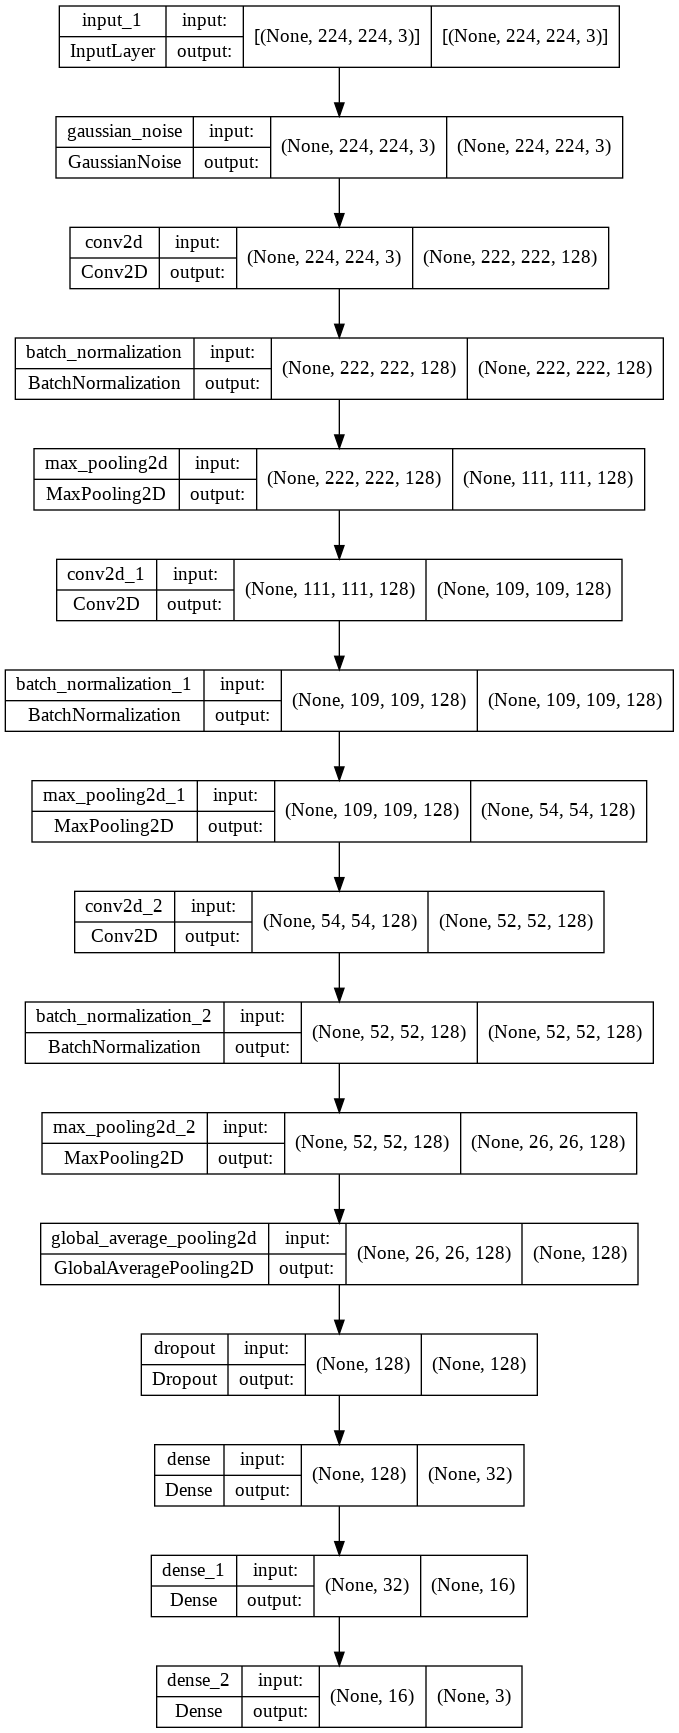

In [12]:
print(model.summary())
plot_model(model, "CNN.png", show_shapes=True)

# **Model Pre-Trained**

In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD

In [14]:
base_model = InceptionV3(weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])

In [16]:
history = model.fit_generator(train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
123/123 [==============================] - 139s 997ms/step - loss: 0.8325 - accuracy: 0.6152 - val_loss: 0.7267 - val_accuracy: 0.6833
Epoch 2/100
123/123 [==============================] - 118s 963ms/step - loss: 0.6744 - accuracy: 0.7043 - val_loss: 0.6005 - val_accuracy: 0.7434
Epoch 3/100
123/123 [==============================] - 118s 962ms/step - loss: 0.6135 - accuracy: 0.7308 - val_loss: 0.5305 - val_accuracy: 0.7668
Epoch 4/100
123/123 [==============================] - 118s 957ms/step - loss: 0.5872 - accuracy: 0.7415 - val_loss: 0.5283 - val_accuracy: 0.7688
Epoch 5/100
123/123 [==============================] - 118s 956ms/step - loss: 0.5782 - accuracy: 0.7520 - val_loss: 0.5096 - val_accuracy: 0.7800
Epoch 6/100
123/123 [==============================] - 116s 942ms/step - loss: 0.5697 - accuracy: 0.7512 - val_loss: 0.5555 - val_accuracy: 0.7699
Epoch 7/100
123/123 [==============================] - 116s 941ms/step - loss: 0.5521 - accuracy: 0.7614 - val_loss: 0

In [17]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=["accuracy"])

history2 = model.fit_generator(train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.

Epoch 1/100
123/123 [==============================] - 128s 981ms/step - loss: 0.7615 - accuracy: 0.7183 - val_loss: 0.4530 - val_accuracy: 0.7933
Epoch 2/100
123/123 [==============================] - 117s 952ms/step - loss: 0.5286 - accuracy: 0.7785 - val_loss: 0.4405 - val_accuracy: 0.8147
Epoch 3/100
123/123 [==============================] - 117s 949ms/step - loss: 0.4659 - accuracy: 0.8086 - val_loss: 0.4188 - val_accuracy: 0.8259
Epoch 4/100
123/123 [==============================] - 116s 947ms/step - loss: 0.4219 - accuracy: 0.8211 - val_loss: 0.4312 - val_accuracy: 0.8198
Epoch 5/100
123/123 [==============================] - 118s 963ms/step - loss: 0.4085 - accuracy: 0.8349 - val_loss: 0.3839 - val_accuracy: 0.8381
Epoch 6/100
123/123 [==============================] - 117s 956ms/step - loss: 0.3758 - accuracy: 0.8400 - val_loss: 0.3612 - val_accuracy: 0.8371
Epoch 7/100
123/123 [==============================] - 119s 964ms/step - loss: 0.3597 - accuracy: 0.8510 - val_loss: 0

In [18]:
json.dump(str(history.history), open(f"{dir_path}/History.pkl", "w"))

In [19]:
json.dump(str(history2.history), open(f"{dir_path}/History2.pkl", "w"))

In [20]:
model.save(f'{dir_path}/model.h5')

# **Assessment**

In [21]:
model = keras.models.load_model(f"{dir_path}/model.h5")
with open(f"{dir_path}/History.pkl",'r') as file:    
    history = eval(file.read().replace('"',"").replace("\'","'"))

## **Loss**

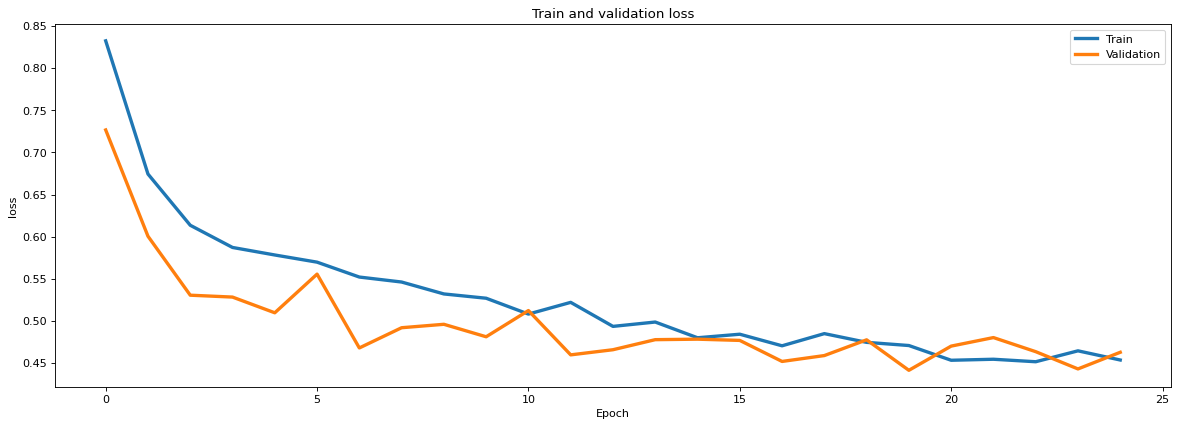

In [22]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')    
plt.plot(history['loss'],linewidth=3)
plt.plot(history['val_loss'],linewidth=3)
plt.title(f'Train and validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

## **Accuracy**

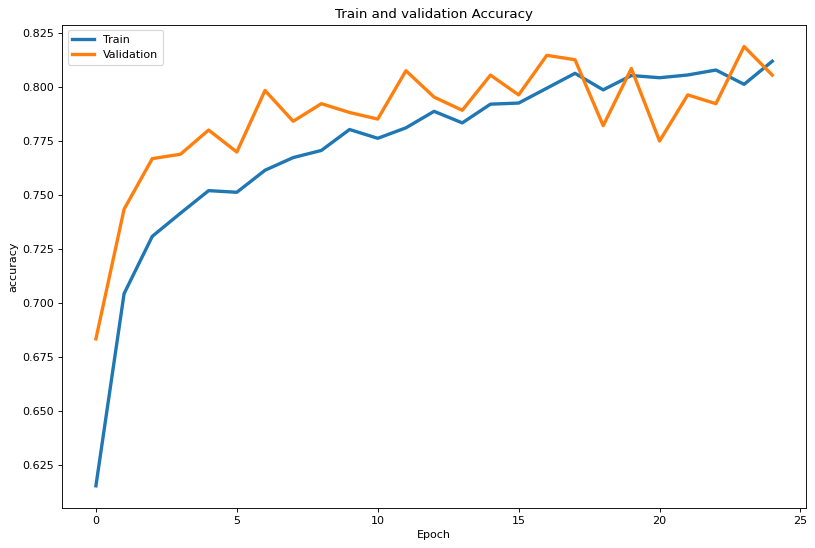

In [23]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')    
plt.plot(history['accuracy'],linewidth=3)
plt.plot(history['val_accuracy'],linewidth=3)
plt.title(f'Train and validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()

  ## **Confusion matrix for Test**

In [24]:
y_true = []
y_pred = []
for i in range(0,len(test_generator)):
    y_true = [*y_true, *[i for i in np.argmax(test_generator[i][1],axis=1)]]    
    y_pred = [*y_pred, *[i for i in np.argmax(model.predict_on_batch(test_generator[i][0]),axis=1)]]      

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


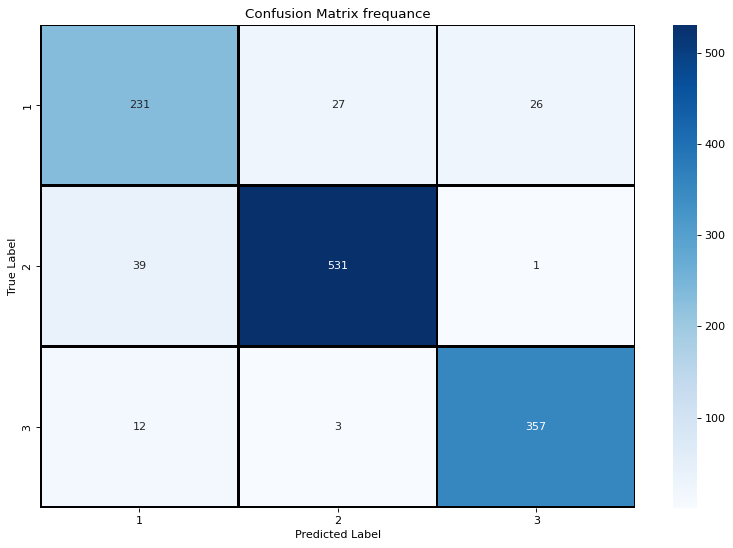

In [25]:
matrix = metrics.confusion_matrix(y_true, y_pred)            
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')        
ax = sns.heatmap(matrix,cmap="Blues",linecolor='black',linewidths=1.7,xticklabels=groups, yticklabels=groups, annot=True,fmt="d")    
plt.title("Confusion Matrix frequance")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

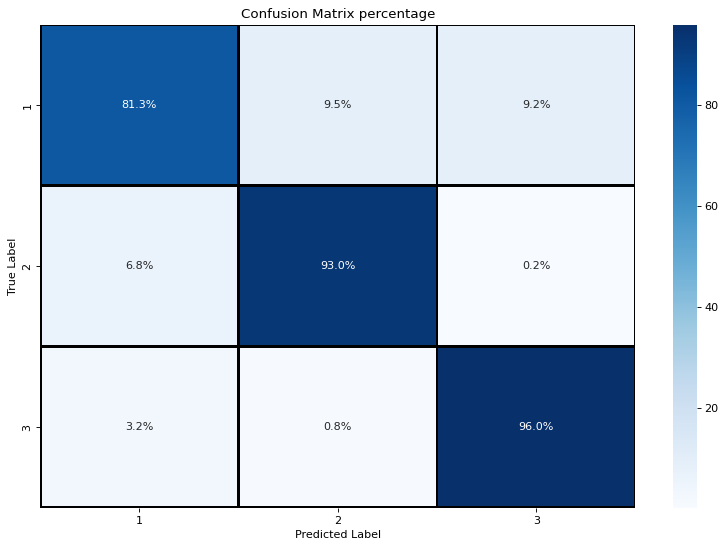

In [26]:
sensitivity =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')        
ax = sns.heatmap(sensitivity,cmap="Blues",linecolor='black',linewidths=1.7,xticklabels=groups, yticklabels=groups, annot=True,fmt=".1f")    
plt.title("Confusion Matrix percentage")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
for t in ax.texts: t.set_text(t.get_text() + "%")
plt.show()

In [28]:
print(classification_report(y_true, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.8191    0.8134    0.8163       284
           1     0.9465    0.9299    0.9382       571
           2     0.9297    0.9597    0.9444       372

    accuracy                         0.9120      1227
   macro avg     0.8985    0.9010    0.8996      1227
weighted avg     0.9119    0.9120    0.9119      1227

